### PISCES Benchmark 

In [3]:
import os
import math
import pickle
import scipy.stats

/scratch/ipykernel_28755/607606379.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis', 256)


In [4]:
working_dir = '.'
results_dir = os.path.join(working_dir, 'results')
data_dir = os.path.join(working_dir,'data')
sequence_file = os.path.join(data_dir, 'sequences.fasta')
tm_scores_path = os.path.join(data_dir, 'TM_scores.pickle')

Load PISCES pairs TM-scores 

In [5]:
with open(tm_scores_path, 'rb') as handle:
    all_tm_scores = pickle.load(handle)
    
print('{} TM scores loaded'.format(len(all_tm_scores)))

40932 TM scores loaded


remove reduntant pairs

In [6]:
tm_scores = dict()
for p in all_tm_scores:
    if (p[1],p[0]) not in tm_scores.keys():
        tm_scores[p]=all_tm_scores[p]
        
print('{} TM scores filtred'.format(len(tm_scores)))

20466 TM scores filtred


Load sequences

In [7]:
sequences = dict()
with open(sequence_file, 'r') as file:
    for line in file:
        if line[0]=='>':
            pdb_id = line.split()[0][1:]
            sequences[pdb_id] = ''
        else:
            sequences[pdb_id]+=line.strip()

seq_length = {seq_id:len(sequences[seq_id])for seq_id in sequences}

Load predictions

In [8]:
results = dict()
for file in os.listdir(results_dir):
    if file=='times':
        continue
    print('loading: {}'.format(file))
    file_path = os.path.join(results_dir,file)
    with open(file_path, 'rb') as handle:
        results[file.split('.')[0]] = pickle.load(handle)

loading: eba_scores_ProstT5.pickle
loading: eba_plain_scores_ProstT5.pickle
loading: ad_ProstT5.pickle


## Compute Spearman correlations

In [11]:
def get_ordered_results(results,tm_scores,AD=False):
    
    if AD:
        ordered_results = list()
    else:
        ordered_results = {'min':list(), 'max':list(), 'raw':list()}

    tm_results = {'tm_min':list(), 'tm_max':list(), 'r':list()}

    for p in results:
        short = min(seq_length[p[0]],seq_length[p[1]])
        long = max(seq_length[p[0]],seq_length[p[1]])

        #remove failed alignments
        n=0
        if p in tm_scores.keys():
            if tm_scores[p]['TM1']==0:
                n+=1
                continue
                
            tm_results['tm_min'].append(min(tm_scores[p]['TM1'], tm_scores[p]['TM2']))
            tm_results['tm_max'].append(max(tm_scores[p]['TM1'], tm_scores[p]['TM2']))
            tm_results['r'].append(short/long)
            
        else:
            continue

        if AD:
            ordered_results.append(results[p])
        else:
            ordered_results['min'].append(results[p]['EBA_min'])
            ordered_results['max'].append(results[p]['EBA_max'])
            ordered_results['raw'].append(results[p]['EBA_raw'])
                
    
    print('Failed alignments: {}'.format(n))
    return ordered_results,tm_results

### ProstT5 example

In [12]:
ProstT5_results, ProstT5_gt = get_ordered_results(results['eba_scores_ProstT5'], tm_scores)
ProstT5_plain_results, ProstT5_plain_gt = get_ordered_results(results['eba_plain_scores_ProstT5'], tm_scores)
ProstT5_AD_results, ProstT5_AD_gt = get_ordered_results(results['ad_ProstT5'], tm_scores, True)

Failed alignments: 0
Failed alignments: 0
Failed alignments: 0


Spearman correlation: EBA-ProstT5

In [13]:
print('tm_min: {}'.format(scipy.stats.spearmanr(ProstT5_results['min'], ProstT5_gt['tm_min'])))
print('tm_max: {}'.format(scipy.stats.spearmanr(ProstT5_results['max'], ProstT5_gt['tm_max'])))

tm_min: SignificanceResult(statistic=0.9196596405495469, pvalue=0.0)
tm_max: SignificanceResult(statistic=0.8604309763155114, pvalue=0.0)


Spearman correlation: EBA_plain-ProstT5

In [14]:
print('tm_min: {}'.format(scipy.stats.spearmanr(ProstT5_plain_results['min'], ProstT5_plain_gt['tm_min'])))
print('tm_max: {}'.format(scipy.stats.spearmanr(ProstT5_plain_results['max'], ProstT5_plain_gt['tm_max'])))

tm_min: SignificanceResult(statistic=0.5592257677313669, pvalue=0.0)
tm_max: SignificanceResult(statistic=0.2046836445952694, pvalue=1.7862820540334617e-192)


Spearman correlation: AD-ProstT5

In [15]:
print('tm_min: {}'.format(scipy.stats.spearmanr(ProstT5_AD_results, ProstT5_plain_gt['tm_min'])))
print('tm_max: {}'.format(scipy.stats.spearmanr(ProstT5_AD_results, ProstT5_plain_gt['tm_max'])))

tm_min: SignificanceResult(statistic=-0.6461896407196344, pvalue=0.0)
tm_max: SignificanceResult(statistic=-0.4867638711785488, pvalue=0.0)


### Plots: ProtT5

In [16]:
import matplotlib.pyplot as plt
from matplotlib import cm
viridis = cm.get_cmap('viridis', 256)

/scratch/ipykernel_28755/1904049256.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis', 256)


In [18]:
colors = ProstT5_gt['r']
plt.xlabel('TM$_{min}$ scores',fontsize='x-large')
plt.ylabel('EBA$_{min}$',fontsize='x-large')
plt.scatter(ProstT5_gt['tm_min'], 
            ProstT5_results['min'],
            alpha=0.5,
            c=colors,
            cmap= viridis,
            vmin=0, vmax=1)
plt.colorbar()
#plt.savefig(fig_path, dpi=100, transparent=True)

### Times


In [45]:
times_dir = os.path.join(results_dir, 'times')
all_times = dict()
for file in os.listdir(times_dir):
    print('loading: {}'.format(file))
    file_path = os.path.join(times_dir,file)
    with open(file_path, 'rb') as handle:
        all_times[file.split('.')[0]] = pickle.load(handle)

loading: ad_ProstT5_times.pickle
loading: TM_align_times.pickle
loading: eba_times_ProstT5.pickle
loading: eba_plain_times_ProstT5.pickle


In [61]:
times = dict()
for k in all_times:
    times[k] = dict()
    for p in all_times[k]:
        if p not in times[k].keys():
            times[k][(p[1],p[0])]=all_times[k][(p[1],p[0])]
        
print('{} times scores filtred'.format(len(tm_scores)))

20466 times scores filtred


In [62]:
t_EBA = list()
t_EBA_plain = list()
t_AD = list()
t_TM = list()
l1 = list()
l2 = list()
l12 = list()

pairs = list()
for p in times['eba_times_ProstT5']:
    pairs.append(p)
    if (p[1],p[0]) in pairs:
        continue
    if times['eba_times_ProstT5'][p]['t']>1:
        print(p)
        #continue
    
    if times['TM_align_times'][p] == {}:
        continue
    t_EBA.append(times['eba_times_ProstT5'][p]['t'])
    t_EBA_plain.append(times['eba_plain_times_ProstT5'][p]['t'])
    t_AD.append(times['ad_ProstT5_times'][p]['t'])
    t_TM.append(times['TM_align_times'][p]['t'])
    l1.append(times['eba_times_ProstT5'][p]['l1'])
    l2.append(times['eba_times_ProstT5'][p]['l2'])
    l12.append(l1[-1]*l2[-1])

In [63]:
len(times['eba_times_ProstT5'])

20619

In [64]:
EBA_avg = sum(t_EBA)/len(t_EBA)
EBA_plain_avg = sum(t_EBA_plain)/len(t_EBA_plain)
TM_avg = sum(t_TM)/len(t_TM)
AD_avg = sum(t_AD)/len(t_AD)

print('Average pairwise timings:\nEBA: {}\nEBA_plain: {}\nTM-aling {}\nAD: {}'.format(EBA_avg,EBA_plain_avg,TM_avg,AD_avg))

Average pairwise timings:
EBA: 0.020975772649279835
EBA_plain: 0.019564786754627913
TM aling 0.17146943152084806
AD: 7.265458460673318e-05


### Plot

In [65]:
times = {'AD':t_AD, 'EBA_plain':t_EBA_plain,'EBA':t_EBA, 'TM-align':t_TM}
labels = {'AD':'AD','EBA':'EBA','EBA_plain':'$EBA_{plain}$','TM-align':'TM-align'}
colors = {'AD':'lightcoral','EBA':'tab:purple','EBA_plain':'tab:pink','TM-align':'tab:blue'}

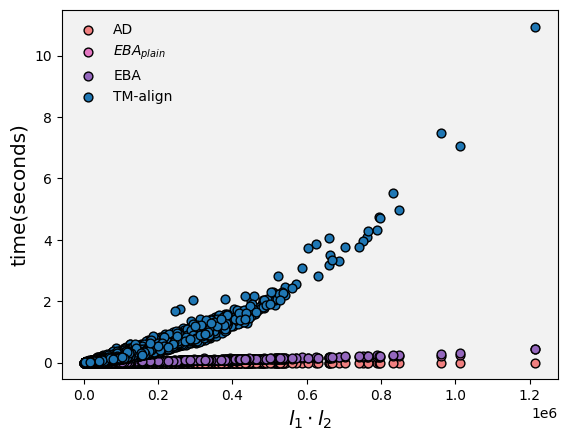

In [66]:
for name in times.keys():
    plt.scatter(l12, times[name], label=labels[name], color=colors[name],
                marker='o', edgecolors="black", s=40)
# Plot
background_color = '#F2F2F2'
plt.gca().set_facecolor(background_color)
plt.ylabel('time(seconds)',fontsize="x-large")
plt.xlabel('$l_1 \cdot l_2$',fontsize="x-large")
plt.legend(frameon=False)#,fontsize="x-large")
#plt.savefig(plots_path, dpi=400)
plt.show()


Apply logarithm

In [67]:
l12 = [math.log(x,10) for x in l12]
t_AD = [math.log(x,10) for x in t_AD]
t_EBA = [math.log(x,10) for x in t_EBA]
t_EBA_plain = [math.log(x,10) for x in t_EBA_plain]
t_TM = [math.log(x,10) for x in t_TM]

In [68]:
times = {'AD':t_AD, 'EBA_plain':t_EBA_plain,'EBA':t_EBA, 'TM-align':t_TM}

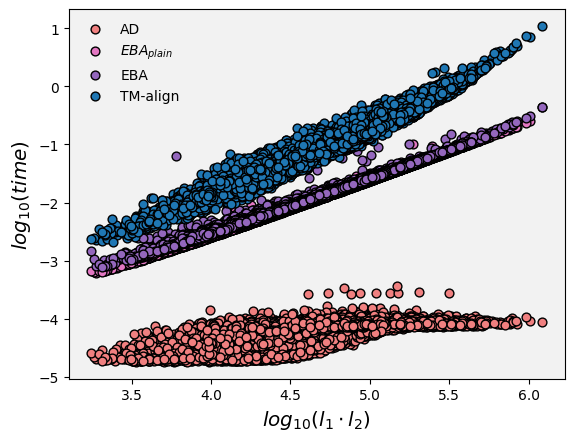

In [69]:
for name in times.keys():
    plt.scatter(l12, times[name], label=labels[name], color=colors[name],
                marker='o', edgecolors="black", s=40)
# Plot
background_color = '#F2F2F2'
plt.gca().set_facecolor(background_color)
plt.ylabel('$log_{10}(time)$',fontsize="x-large")
plt.xlabel('$log_{10}(l_1 \cdot l_2)$',fontsize="x-large")
plt.legend(frameon=False)#,fontsize="x-large")
#plt.savefig(plots_paths, dpi=400)
plt.show()